In [1]:
import numpy as np
import sacc
import matplotlib.pyplot as plt
import pyccl as ccl
import scipy
import importlib as imp
import astropy.io.fits as fits

import CM_code.spurious_george as sp
imp.reload(sp)
import CM_code.halo_model as halo
imp.reload(halo)
import CM_code.lsst_coZmology as zed
imp.reload(zed)

# import main.py from TJPCov folder
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator

data_dir = '/home/b7009348/WGL_project/DES-data/'
lens_file = data_dir+'DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits'
source_Zs = data_dir+'mof_BPZ_(stacking).fits'
im3_file_full = data_dir+'y1_im3_shapes_matched.fits'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

## Start with DES

### Create SACC object to be passed to TJP

In [2]:
# Load in DES redshift data

# load in im3 data 
with fits.open(im3_file_full) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    im3_weight = data['weight']
del data

# load in z_mc for all sources
with fits.open(source_Zs) as hdu:
    data = hdu[1].data
    source_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']  
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
source_zmc = source_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

with fits.open(lens_file) as hdu:
    data = hdu[1].data
    lens_z = data['ZREDMAGIC']
    w_l = data['WEIGHT']
del data

nbins = 299

im3_dndz, im3_bins = np.histogram(source_zmc, bins=nbins, weights=im3_weight)
lens_dndz, lens_bins = np.histogram(lens_z, bins=nbins, weights=w_l)

del w_l, lens_z, source_zmc

In [42]:
theta_eff = s.get_theta_xi('galaxy_shearDensity_xi_t', 'lens', 'source')[0]
nbpw = theta_eff.size

thetab_min, thetab_max = theta_eff.min(), theta_eff.max()

del_logtheta = np.log10(theta_eff[1:] / theta_eff[:-1]).mean()
theta_min = 2 * thetab_min / (10**del_logtheta + 1)
theta_max = 2 * thetab_max / (1 + 10 ** (-del_logtheta))

th_min = theta_min
th_max = theta_max
theta_edges = np.logspace(
    np.log10(th_min), np.log10(th_max), nbpw + 1
)
th = np.logspace(np.log10(th_min * 0.98), np.log10(1), nbpw * 30)
# binned covariance can be sensitive to the th values. Make sure
# you check convergence for your application
th2 = np.linspace(1, th_max * 1.02, nbpw * 30)

theta = np.unique(np.sort(np.append(th, th2)))
print(theta)

[  1.           1.00203507   1.00407429   1.00611765   1.00816517
   1.01021686   1.01227273   1.01433278   1.01639702   1.01846546
   1.02053811   1.02261498   1.02469607   1.02678141   1.02887098
   1.03096481   1.0330629    1.03516525   1.03727189   1.03938281
   1.04149803   1.04361756   1.04574139   1.04786955   1.05000205
   1.05213888   1.05428005   1.05642559   1.05857549   1.06072977
   1.06288843   1.06505149   1.06721895   1.06939081   1.0715671
   1.07374782   1.07593297   1.07812258   1.08031663   1.08251516
   1.08471815   1.08692563   1.08913761   1.09135408   1.09357506
   1.09580057   1.0980306    1.10026518   1.10250429   1.10474797
   1.10699621   1.10924903   1.11150643   1.11376843   1.11603503
   1.11830624   1.12058208   1.12286254   1.12514765   1.12743741
   1.12973182   1.13203091   1.13433467   1.13664313   1.13895628
   1.14127414   1.14359671   1.14592402   1.14825605   1.15059284
   1.15293438   1.15528068   1.15763176   1.15998763   1.16234829
   1.164713

In [41]:
# create DES sacc file
s = sacc.Sacc()

th_des = np.logspace(np.log10(2.5),np.log10(250),10)

s.add_tracer('NZ','lens', z=lens_bins[:-1], nz=lens_dndz)
s.add_tracer('NZ','source', z=im3_bins[:-1], nz=im3_dndz)

A_IA = 0.5 * np.ones(len(im3_bins[:-1]))

lensTracer = ccl.NumberCountsTracer(zed.cosmo_SRD, has_rsd=False, dndz=(lens_bins[:-1], lens_dndz), 
                                    bias=(lens_bins[:-1], 1.6*np.ones(len(lens_dndz))))
shearTracer = ccl.WeakLensingTracer(zed.cosmo_SRD, (im3_bins[:-1], im3_dndz), has_shear=True, 
                                     ia_bias=(im3_bins[:-1], A_IA))

DESintrinsicTracer = ccl.WeakLensingTracer(zed.cosmo_SRD, (im3_bins[:-1], im3_dndz), has_shear=False, 
                                     ia_bias=(im3_bins[:-1], A_IA))

ell_des = np.unique(np.geomspace(180/(th_des[-1]/60.) - 10, 180/(th_des[0]/60.) + 10, 1024).astype(int))

Cl_des = ccl.angular_cl(zed.cosmo_SRD, lensTracer, shearTracer, ell_des)

DES_xi = ccl.correlation(zed.cosmo_SRD, ell_des, Cl_des, th_des/60., type='NG')

s.add_theta_xi('galaxy_shearDensity_xi_t', 'lens', 'source', th_des, DES_xi)

s.save_fits('forecast_tracer_data_DES-y1.fits', overwrite=True)

In [43]:
# define function to automatically set up configuration dictionary for TJP

def configure_covariance(cosmo, sacc_file, cov_type, Nlen, Nsrc, sig_e, len_bias, IA=None, add_keys=None):
    
    config = {}
    config['tjpcov'] = {}
    config['tjpcov']['cosmo'] = cosmo
    config['tjpcov']['sacc_file'] = sacc_file
    config['tjpcov']['cov_type'] = cov_type
    config['tjpcov']['Ngal_lens'] = Nlen
    config['tjpcov']['Ngal_source'] = Nsrc
    config['tjpcov']['sigma_e_source'] = sig_e
    config['tjpcov']['bias_lens'] = len_bias
    config['tjpcov']['IA'] = IA
    
    if add_keys is not None:
        
        for i in range(len(add_keys)):
            
            if add_keys[i][0] not in config:
                
                config[add_keys[i][0]] = {}
                
            for j in range(len(add_keys[i])-1):
                
                config[add_keys[i][0]][add_keys[i][j+1][0]] = add_keys[i][j+1][1]
    
    return config

In [44]:
# ----------------------- DES configs ----------------------------
rho = 0.2

mcal_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_DES-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=0.138, Nsrc=3.26, sig_e=0.28, len_bias=1.6, IA=0.5,
                                   add_keys=[['ProjectedReal',['lmax', 4330]],['GaussianFsky',['fsky', 0.12]]])

mcalXim3_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_DES-y1.fits',
                                    cov_type='RealGaussianFsky', Nlen=0.138, Nsrc=3.26, sig_e=np.sqrt(rho*0.28*0.28), 
                                    len_bias=1.6, IA=0.5,
                                    add_keys=[['ProjectedReal',['lmax', 4330]],['GaussianFsky',['fsky', 0.12]]])

im3_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_DES-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=0.138, Nsrc=3.26, sig_e=0.28, len_bias=1.6, IA=0.5,
                                   add_keys=[['ProjectedReal',['lmax', 4330]],['GaussianFsky',['fsky', 0.12]]])

im3Xmcal_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_DES-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=0.138, Nsrc=3.26, sig_e=np.sqrt(rho*0.28*0.28),
                                    len_bias=1.6, IA=0.5,
                                    add_keys=[['ProjectedReal',['lmax', 4330]],['GaussianFsky',['fsky', 0.12]]])

In [45]:
# do covaraince calculations for DES 

cov = CovarianceCalculator(mcal_config)
cov_mcal = cov.get_covariance()

cov = CovarianceCalculator(im3_config)
cov_im3 = cov.get_covariance()

cov = CovarianceCalculator(mcalXim3_config)
cov_mcalXim3 = cov.get_covariance()

cov = CovarianceCalculator(im3Xmcal_config)
cov_im3Xmcal = cov.get_covariance()

DES_cov_IA = cov_mcal + cov_im3 - cov_mcalXim3 - cov_im3Xmcal 

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')


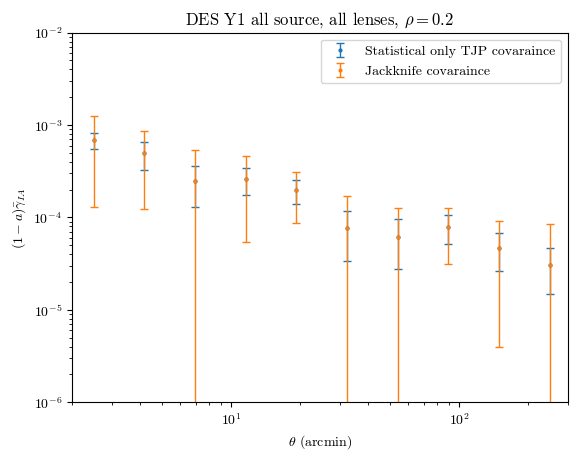

In [46]:
gamIA = full['IA']
boost = full['boost']
F = full['F']

tjp_err = np.sqrt(np.diag(DES_cov_IA)) / (boost - 1. + F)
jck_cov = jack['IA_cov']
jck_err = np.sqrt(np.diag(jack['IA_cov']))

plt.figure()
plt.errorbar(th_des, gamIA, tjp_err, linewidth=0., markersize=2., marker='o', elinewidth=1.,capsize=3)
plt.errorbar(th_des, gamIA, jck_err, linewidth=0., markersize=2., marker='o', elinewidth=1.,capsize=3)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2,300])
plt.title(r'DES Y1 all source, all lenses, $\rho = 0.2$')
plt.xlabel(r'$\theta $ (arcmin)')
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}$')
plt.legend(['Statistical only TJP covaraince','Jackknife covaraince'])

In [58]:
tjp_snr = np.sqrt(gamIA.T @ np.linalg.inv(DES_cov_IA) @ gamIA)
print(tjp_snr)
jck_snr = np.sqrt(gamIA.T @ np.linalg.inv(jck_cov) @ gamIA)
print(jck_snr)

91.47931291605508
3.3620005848229346


In [69]:
no_cov = np.zeros([10,10])
for j in range(10):
    for i in range(10):
        if i==j:
            no_cov[i,j] = DES_cov_IA[i,j]

tjp_nocov = np.sqrt(gamIA.T @ np.linalg.inv(no_cov) @ gamIA)
print(tjp_nocov)

101.58316126980706


In [18]:
print('Jackknife cov', jck_err)
print('TJPCov',tjp_err)
print('IA',gamIA)

Jackknife cov [5.60793552e-04 3.70129561e-04 2.95898149e-04 2.05486202e-04
 1.12197099e-04 9.44077257e-05 6.57425841e-05 4.73528565e-05
 4.33000348e-05 5.53847566e-05]
TJPCov [9.06163856e-08 2.77946603e-07 8.25153624e-07 2.39947213e-06
 6.90456071e-06 1.94101731e-05 5.21894393e-05 1.25646705e-04
 2.24757115e-04 1.94907447e-04]
IA [6.91022551e-04 4.92418498e-04 2.45885294e-04 2.59319535e-04
 1.98424084e-04 7.62201303e-05 6.12030161e-05 7.82848446e-05
 4.72200062e-05 3.04836266e-05]


In [50]:
# create LSST sacc file
s = sacc.Sacc()

th_lsst = sp.theta_cents #forecasts

# start by adding redshift data (this will be used internally by TJP
# to create WL and NC tracers
z_l, dndz_l, zleff = zed.get_dndz_spec('lens')
s.add_tracer('NZ','lens', z=z_l, nz=dndz_l)

z_s, dndz_s, zseff = zed.get_dndz_spec('source')
s.add_tracer('NZ','source', z=z_s, nz=dndz_s)

fred = 0.16
A_IA = fred * 5. * np.ones(len(z_l))

# fred * A_IA = 0.8

lensTracer = ccl.NumberCountsTracer(zed.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                    bias=(z_l, sp.lens_bias(z_l)))
shearTracer = ccl.WeakLensingTracer(zed.cosmo_SRD, (z_s, dndz_s), has_shear=True, 
                                     ia_bias=(z_s, A_IA))

LSSTintrinsicTracer = ccl.WeakLensingTracer(zed.cosmo_SRD, (z_s, dndz_s), has_shear=False, 
                                     ia_bias=(z_s, A_IA))

ell = np.unique(np.geomspace(180/(th_lsst[-1]/60.) - 10, 180/(th_lsst[0]/60.) + 10, 1024).astype(int))

Cl = ccl.angular_cl(zed.cosmo_SRD, lensTracer, shearTracer, ell, limber_integration_method='spline')

LSST_xi = ccl.correlation(zed.cosmo_SRD, ell, Cl, th_lsst/60., type='NG')

s.add_theta_xi('galaxy_shearDensity_xi_t', 'lens', 'source', th_lsst, LSST_xi)

s.save_fits('forecast_tracer_data_lsst-y1.fits', overwrite=True)

In [51]:
# ----------------- LSST configs ---------------------------------


lsst_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_lsst-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=18., Nsrc=10, sig_e=0.13, len_bias=1.5, IA=0.8,
                                   add_keys=[['ProjectedReal',['lmax', 42427]],['GaussianFsky',['fsky', 18000/41253]]])

lsstX_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_lsst-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=18., Nsrc=10, sig_e=np.sqrt(rho*0.13*0.13), 
                                    len_bias=1.5, IA=0.8, 
                                    add_keys=[['ProjectedReal',['lmax', 42427]],['GaussianFsky',['fsky', 18000/41253]]])

In [52]:
cov = CovarianceCalculator(lsst_config)
cov_same = cov.get_covariance()

cov = CovarianceCalculator(lsstX_config)
cov_cross = cov.get_covariance()

LSST_cov_IA = 2.*cov_same - 2.*cov_cross 

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')


In [57]:
np.savez(file='generated_data/lsst-y1-gamma-gamma-covmat', cov=LSST_cov_IA, rho=rho)
print(np.sqrt(np.diag(LSST_cov_IA)))
print(rho)

[2.03368457e-06 1.82869649e-06 1.41391339e-06 1.05602593e-06
 8.48819102e-07 6.89236742e-07 5.64076211e-07 4.60588789e-07
 3.74032721e-07 3.09184293e-07]
0.2


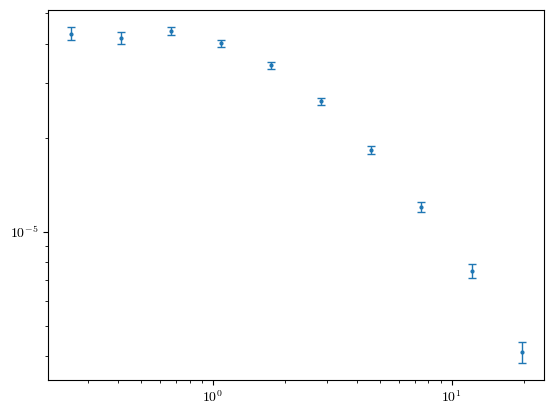

In [55]:
Cl_IA = ccl.angular_cl(zed.cosmo_SRD, lensTracer, LSSTintrinsicTracer, ell)

gammaIA = ccl.correlation(zed.cosmo_SRD, ell, Cl_IA, th_lsst/60., type='NG')

IAerr = np.sqrt(np.diag(LSST_cov_IA))

plt.figure()
plt.errorbar(sp.theta_cents, -(1.-0.5)*gammaIA, IAerr, linewidth=0., markersize=2., marker='o', elinewidth=1., capsize=3)
plt.xscale('log')
plt.yscale('log')

In [56]:
np.linalg.cholesky(LSST_cov_IA)

array([[ 2.03368457e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.46464926e-06,  1.09495817e-06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.94643529e-07,  8.66838484e-07,  1.09993455e-06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.60713745e-08,  4.81862121e-08,  2.89428936e-07,
         1.01380402e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.60468854e-08, -5.18054847e-10,  8.72035346e-08,
         2.28074486e-07,  8.12522450e-07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.

## Code to produce covariances for different values of rho

In [19]:
rho = [0.2,0.4,0.6,0.8]

lsst_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_lsst-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=18., Nsrc=10, sig_e=0.13, len_bias=1.5, IA=0.8,
                                   add_keys=[['ProjectedReal',['lmax', 42427]],['GaussianFsky',['fsky', 18000/41253]]])
LSST_covs = []
    
for value in rho:

    lsstX_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_lsst-y1.fits',
                                       cov_type='RealGaussianFsky', Nlen=18., Nsrc=10, sig_e=np.sqrt(value*0.13*0.13), 
                                        len_bias=1.5, IA=0.8, 
                                        add_keys=[['ProjectedReal',['lmax', 42427]],['GaussianFsky',['fsky', 18000/41253]]])
    
    cov = CovarianceCalculator(lsst_config)
    cov_same = cov.get_covariance()

    cov = CovarianceCalculator(lsstX_config)
    cov_cross = cov.get_covariance()

    LSST_covs.append(2.*cov_same - 2.*cov_cross) 
    
np.savez(file='generated_data/lsst-y1-covmats-IA', cov=LSST_covs, rho=rho)

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'so

## Testing for what might be breaking LSST covariances
- Looks like the problem was down to having too large an intrinsic alingment amplitude because I wasn't accounting for $f_{red}$

In [ ]:
lsst_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_lsst-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=18., Nsrc=10., sig_e=0.13, len_bias=1.5, IA=0.8,
                                   add_keys=[['ProjectedReal',['lmax', 42427]],['GaussianFsky',['fsky', 0.436]]])

lsstX_config = configure_covariance(cosmo=zed.cosmo_SRD, sacc_file='forecast_tracer_data_lsst-y1.fits',
                                   cov_type='RealGaussianFsky', Nlen=18., Nsrc=10., sig_e=np.sqrt(0.2*0.13*0.13), len_bias=1.5, IA=0.8,
                                   add_keys=[['ProjectedReal',['lmax', 42427]],['GaussianFsky',['fsky', 0.436]]])

cov = CovarianceCalculator(lsst_config)
cov_same = cov.get_covariance()

cov = CovarianceCalculator(lsstX_config)
cov_cross = cov.get_covariance()

test_cov = 2.*cov_same - 2.*cov_cross

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


In [ ]:
np.linalg.cholesky(test_cov)

In [14]:
np.diag(np.linalg.inv(test_cov))

array([9.90535053e+28, 3.16023495e+28, 7.26371957e+26, 1.96529388e+24,
       8.37185095e+20, 1.00535314e+17, 2.95160814e+13, 1.96741314e+12,
       2.52887944e+12, 3.39267004e+12])

In [14]:
print(sacc.standard_types)

KeyboardInterrupt: 